In [43]:
import os
import sys
import torch
import uproot
import numpy as np
from collections import OrderedDict, defaultdict
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pickle
import argparse

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

from Common import *
import time
import imp

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
module = "./PuppiJetMETHTModel.py"
weights = "./PuppiJetMETHT_NoCut_Deep_200Epoch.pth"
modulename = 'ZhenbinModel'
exec("from %s import *" % modulename)
sys.stdout = open("%s.log" % modelname, 'w')

start = time.time()
features = sum([v[0] for b, v in PhysicsObt.items()])


model = autoencoder(features)
model.load_state_dict(torch.load(weights, map_location='cpu'))

if torch.cuda.is_available():
    model = model.cuda()
print (model.parameters)

In [16]:
criterion = torch.nn.L1Loss(reduction='none')

for sample in sampleMap:
    sampleMap[sample]['loader'] = DataLoader(P2L1NTP(sampleMap[sample]['file'], PhysicsObt,  cutfunc=globalcutfunc), 
                                       batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=False)
    for i, data in enumerate(sampleMap[sample]['loader']):
        output = model(data)
        loss = criterion(output, data).detach().numpy().astype(np.float32)
        if i == 0:
            sampleMap[sample]['input'] = data.numpy().astype(np.float32)
            sampleMap[sample]['latent'] = model.encoder(data).detach().numpy().astype(np.float32)
            sampleMap[sample]['output'] = output.detach().numpy().astype(np.float32)
            sampleMap[sample]['loss'] = loss
        else:
            sampleMap[sample]['input'] = np.concatenate((sampleMap[sample]['input'], data.numpy().astype(np.float32)), axis=0)
            sampleMap[sample]['latent'] = np.concatenate((sampleMap[sample]['latent'], model.encoder(data).detach().numpy().astype(np.float32)), axis=0)
            sampleMap[sample]['output'] = np.concatenate((sampleMap[sample]['output'], output.detach().numpy().astype(np.float32)), axis=0)
            sampleMap[sample]['loss'] = np.concatenate((sampleMap[sample]['loss'], loss), axis=0)
            

### Compare Input/Output for different processes

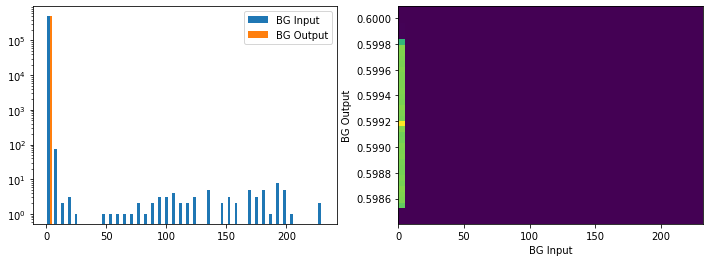

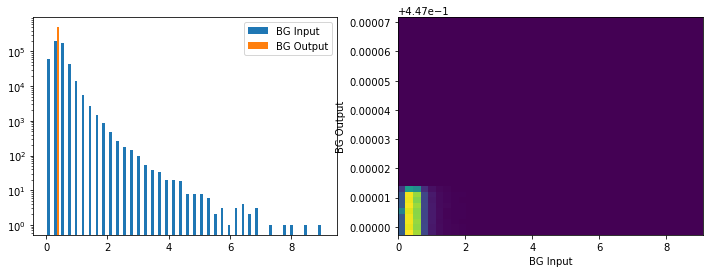

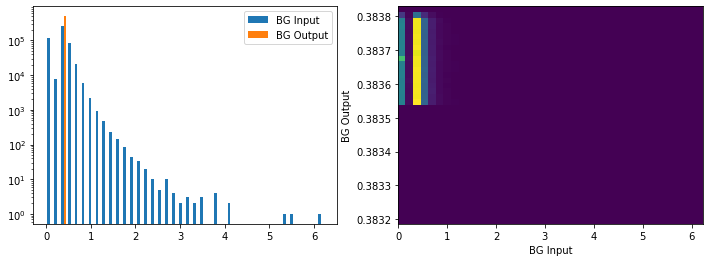

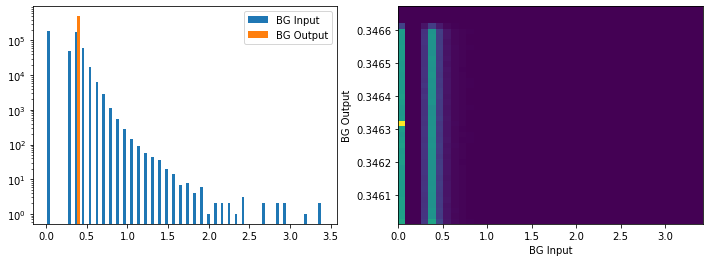

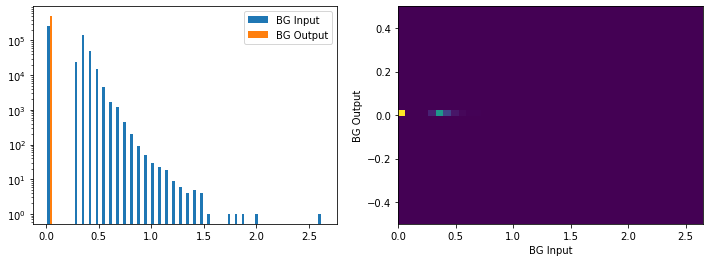

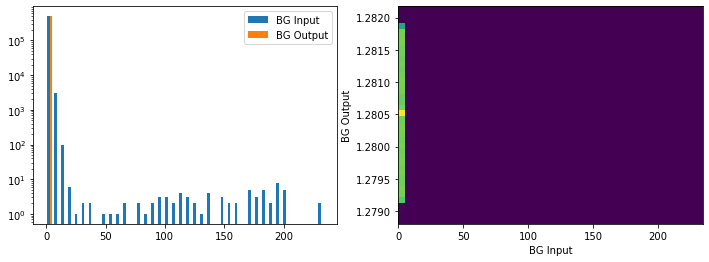

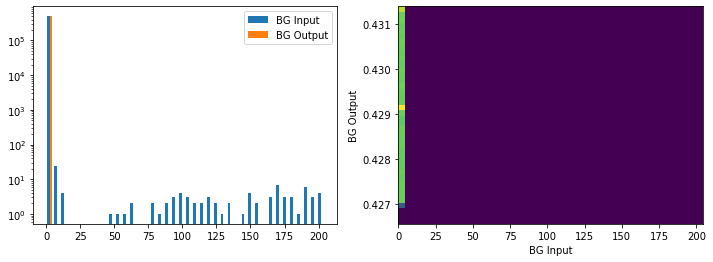

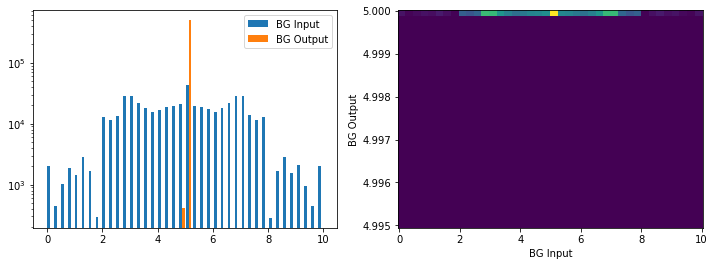

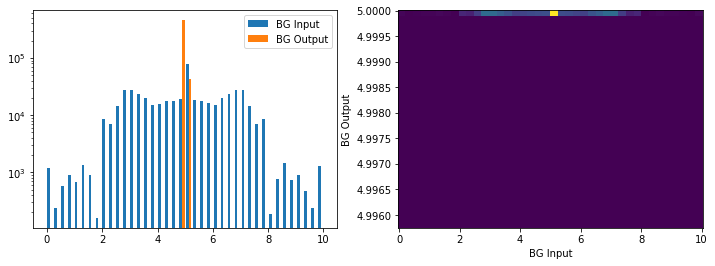

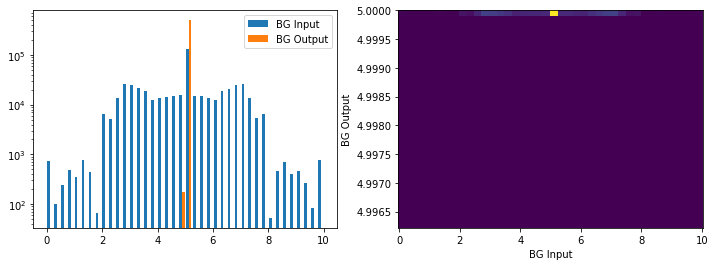

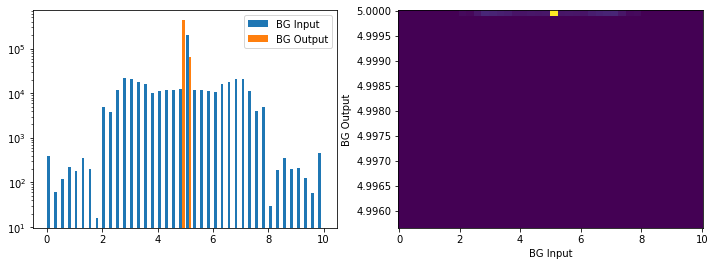

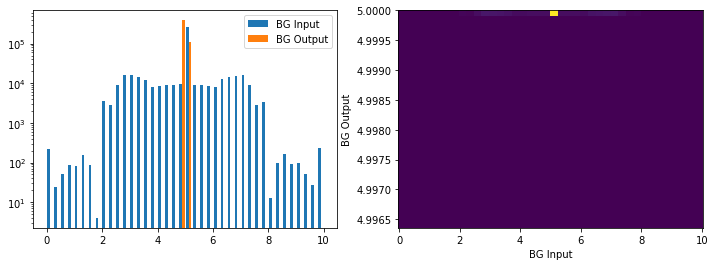

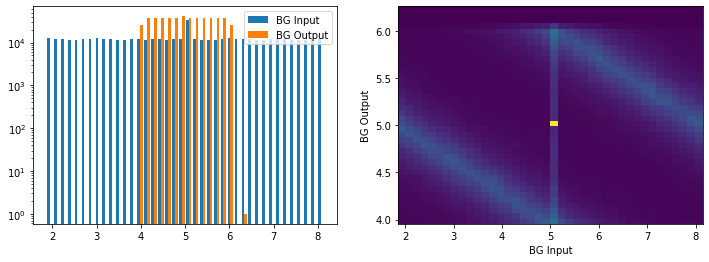

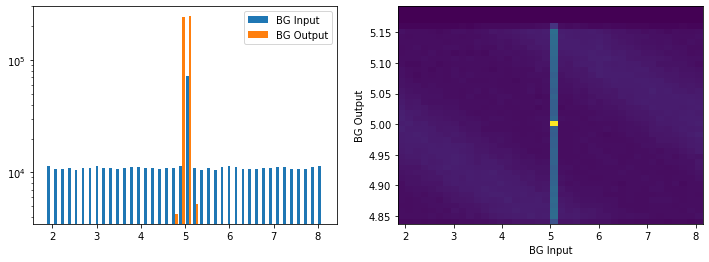

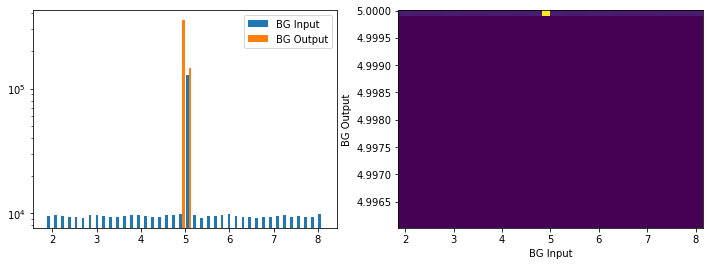

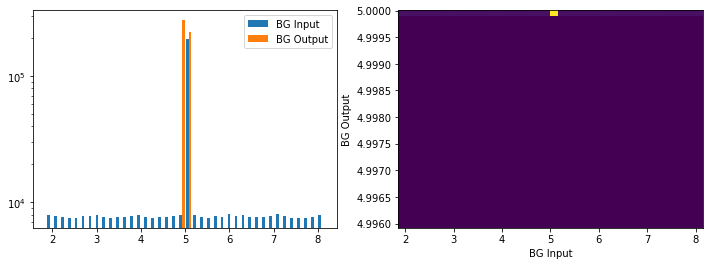

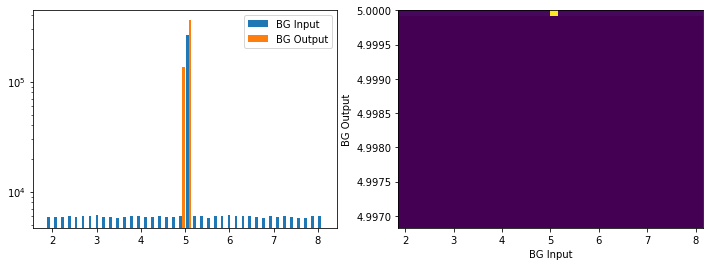

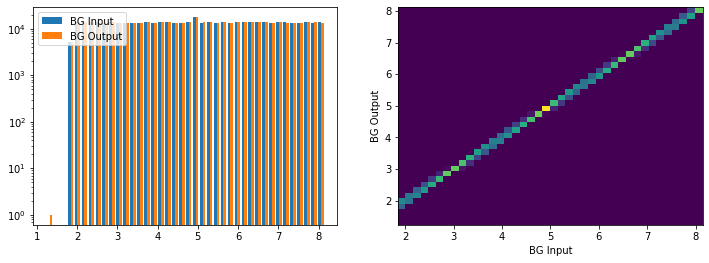

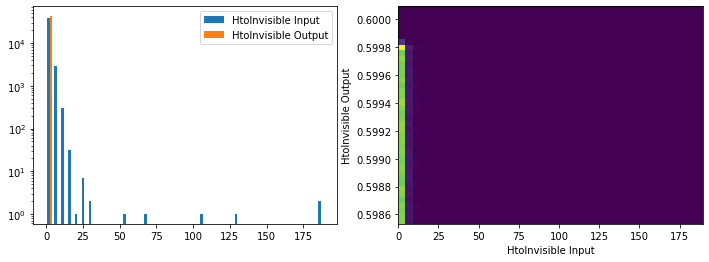

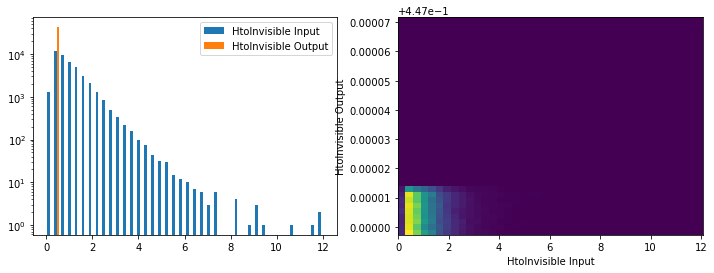

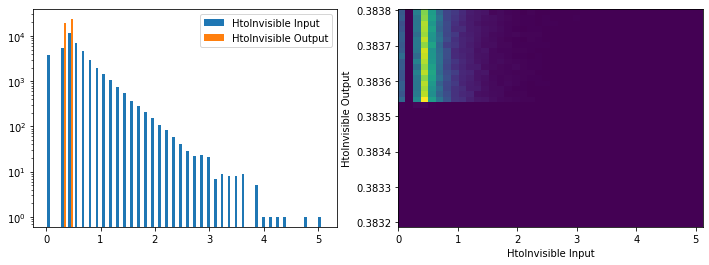

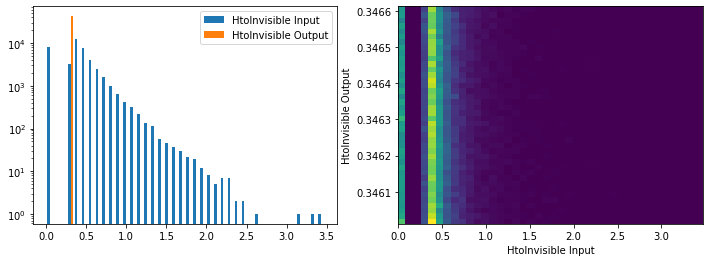

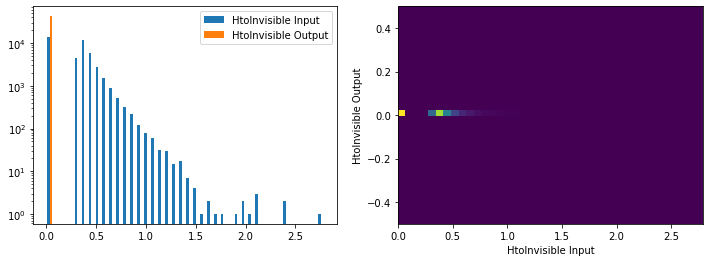

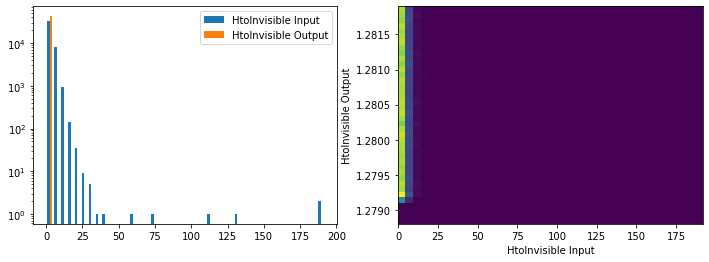

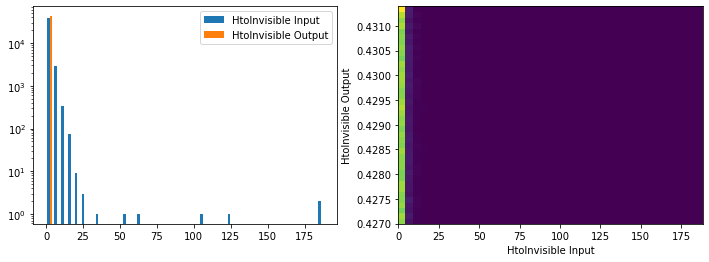

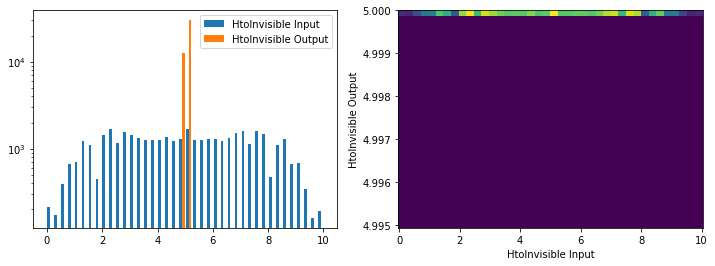

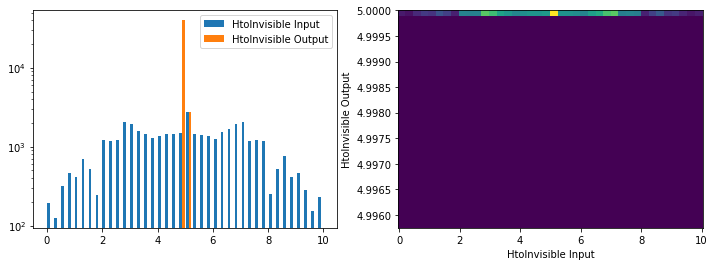

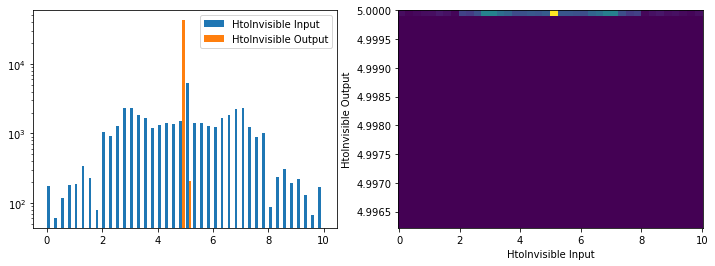

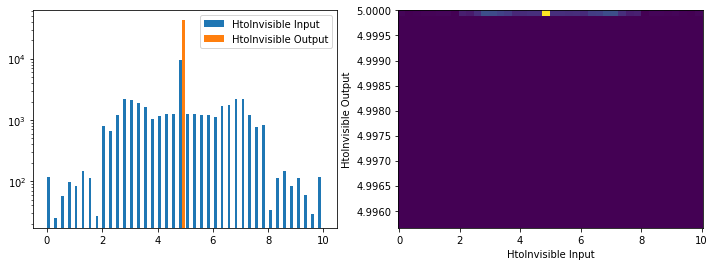

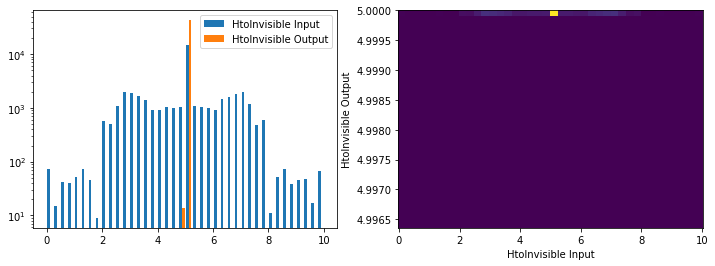

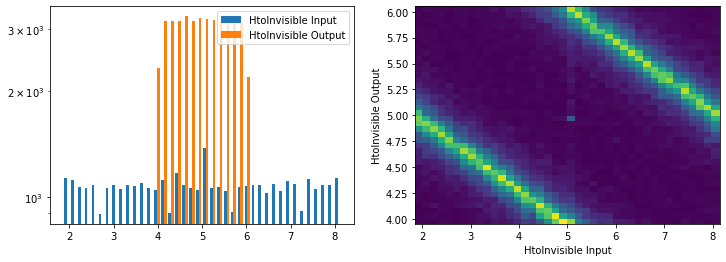

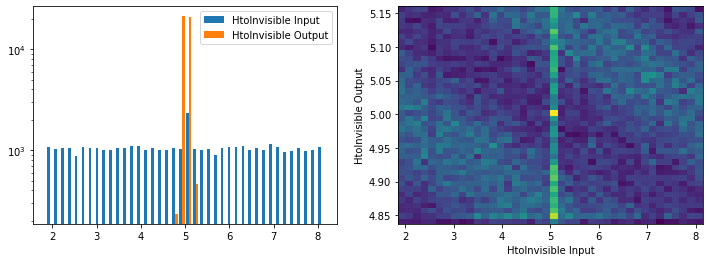

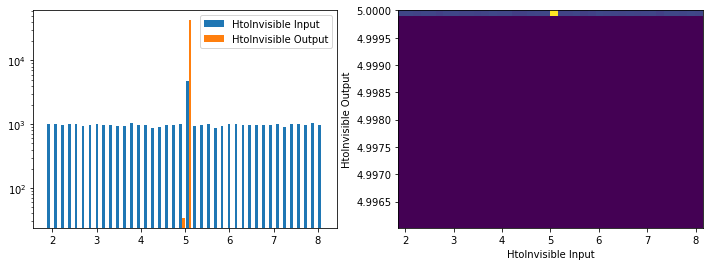

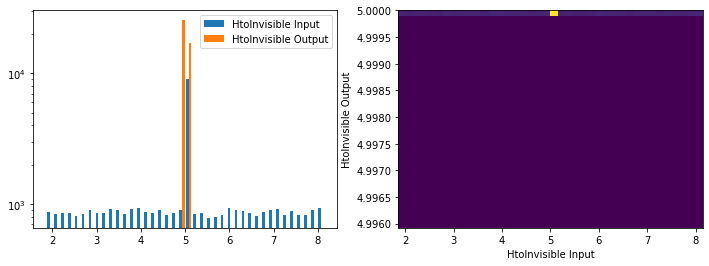

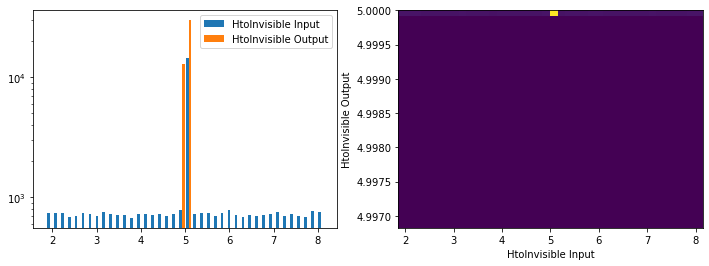

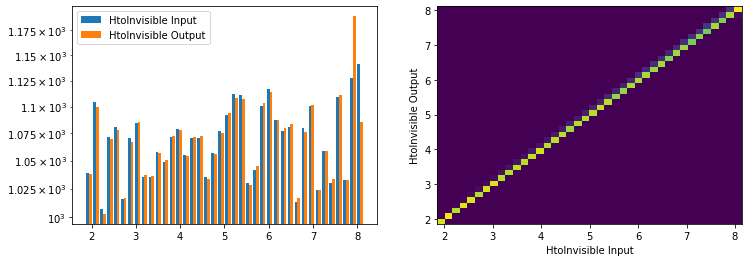

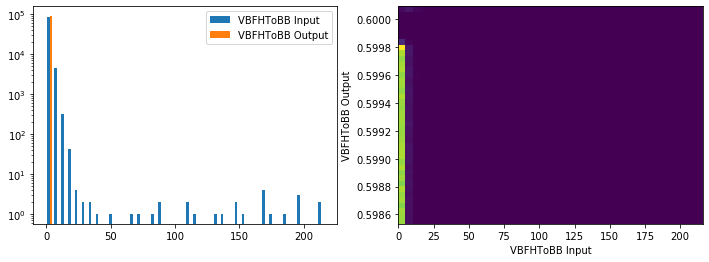

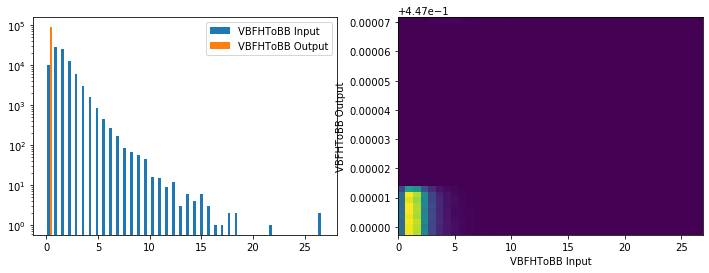

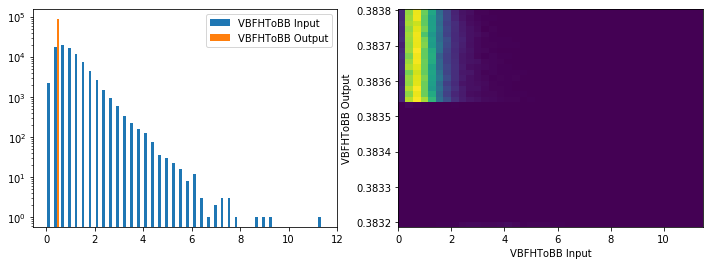

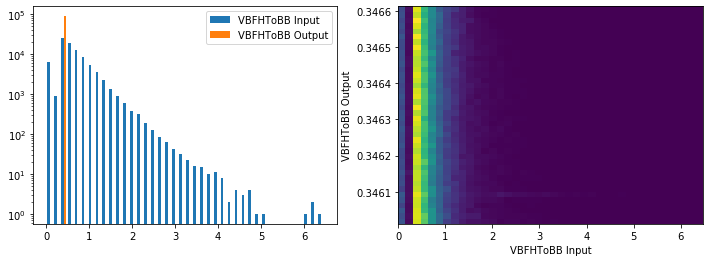

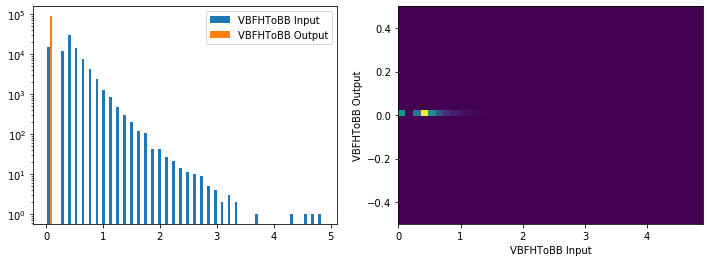

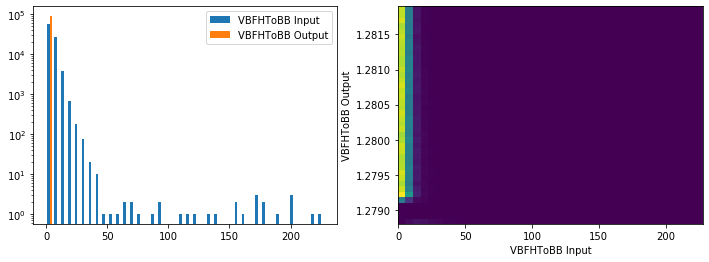

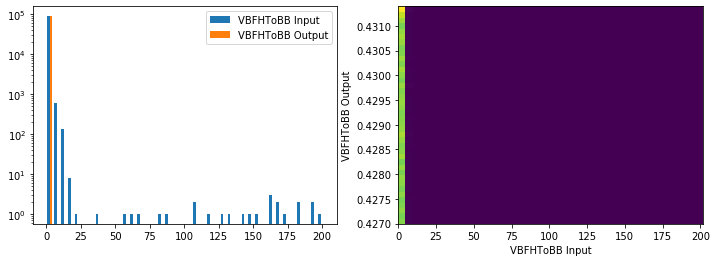

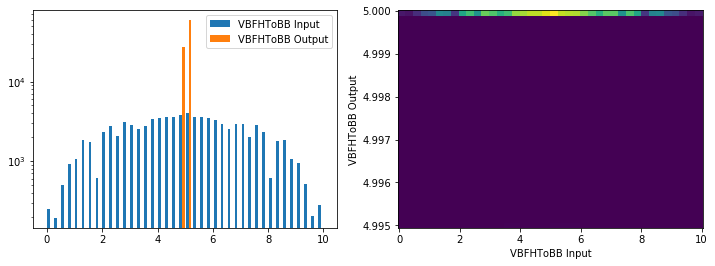

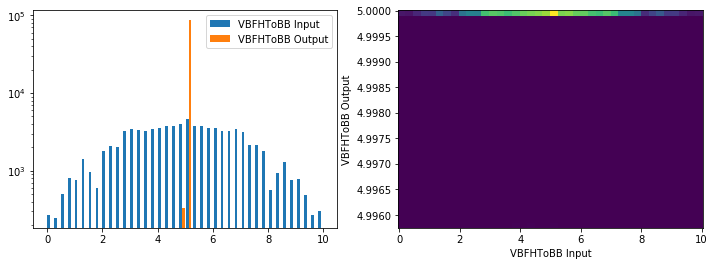

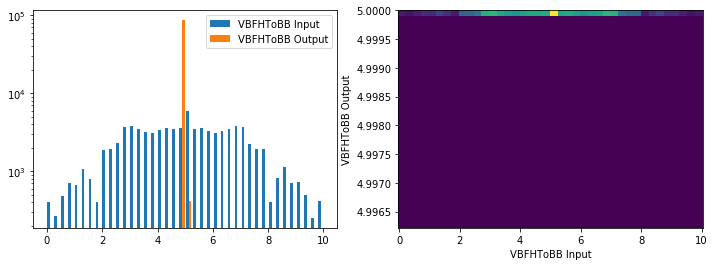

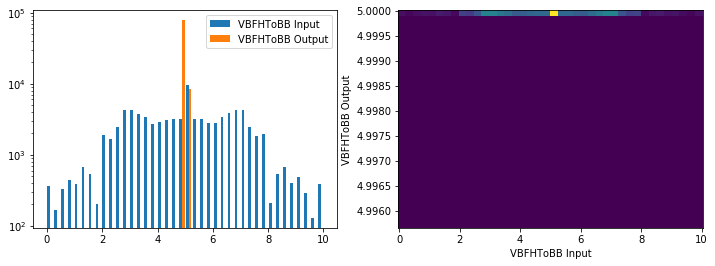

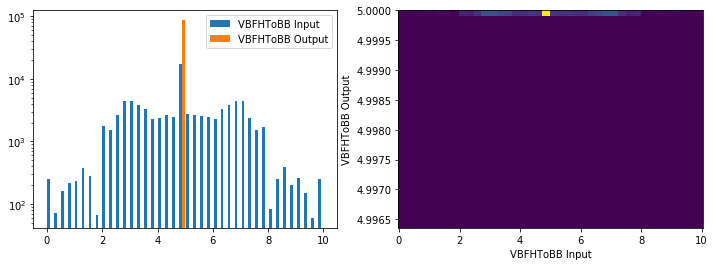

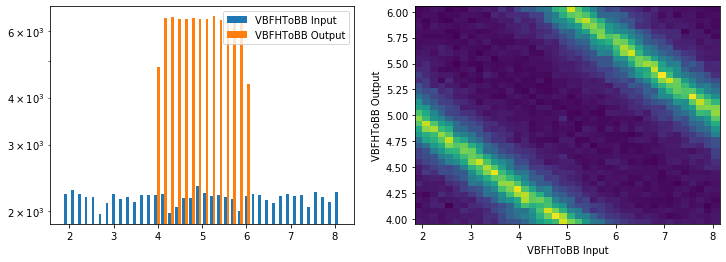

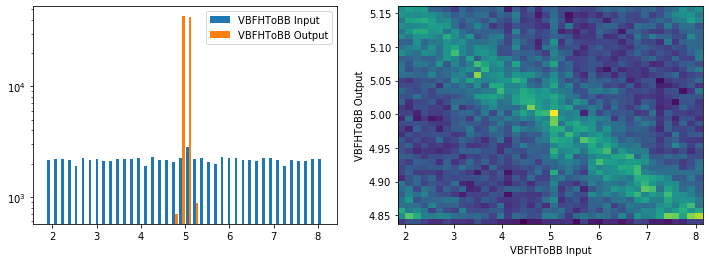

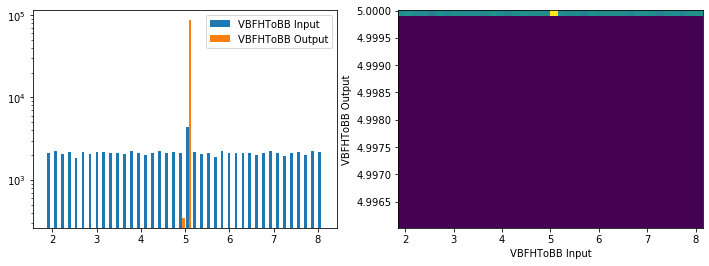

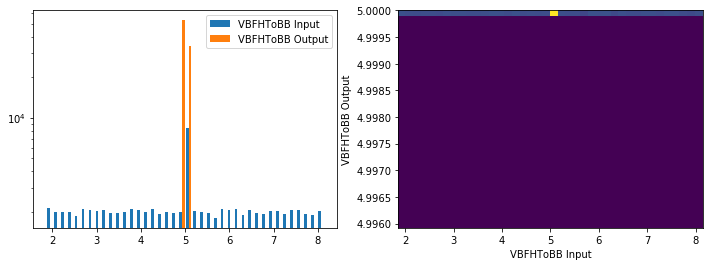

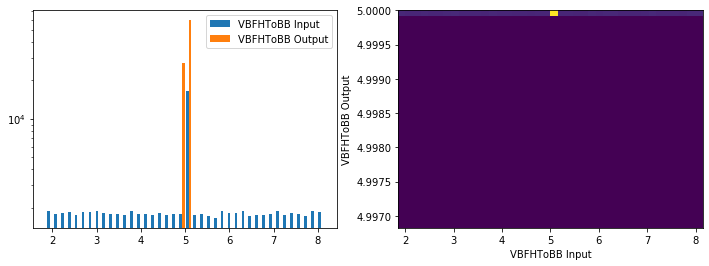

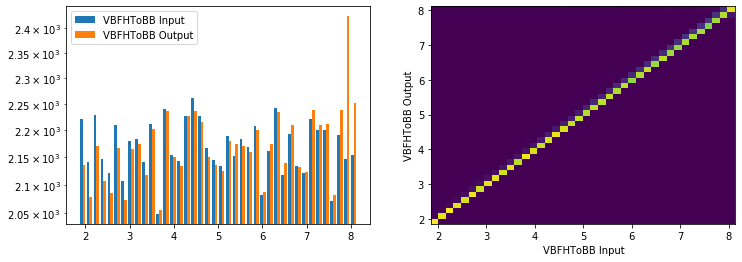

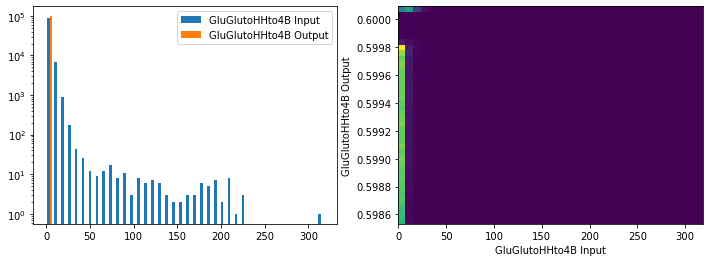

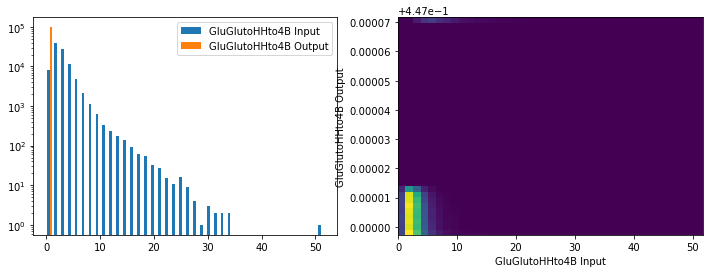

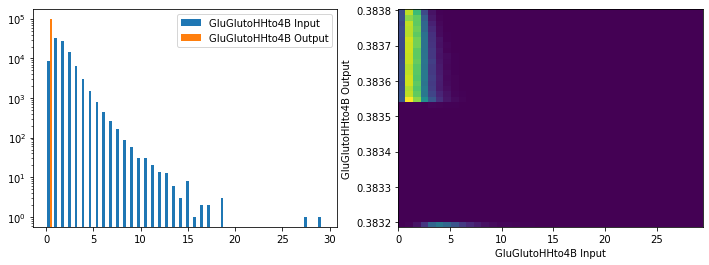

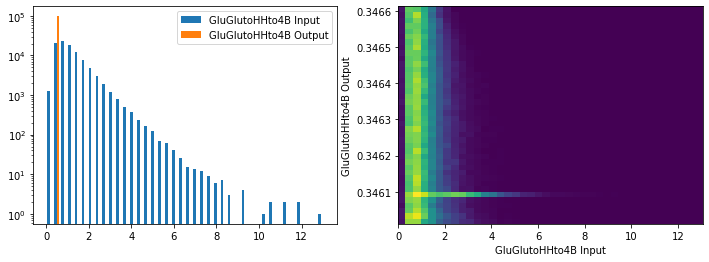

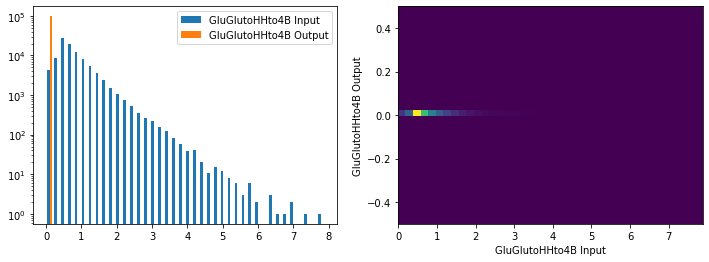

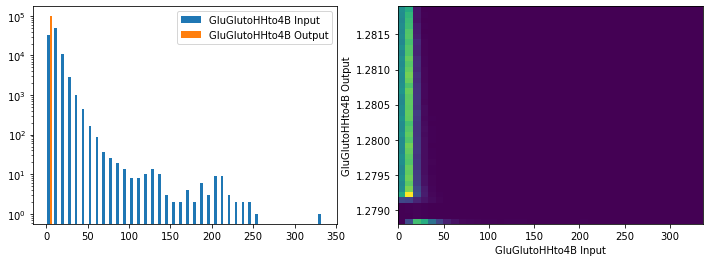

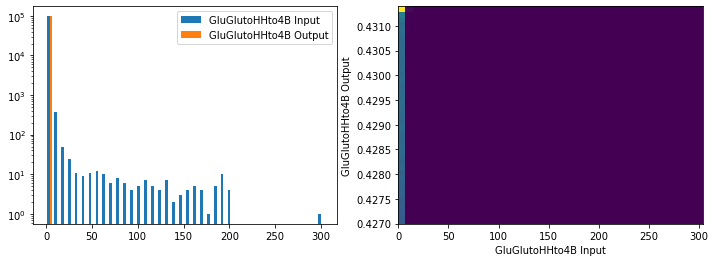

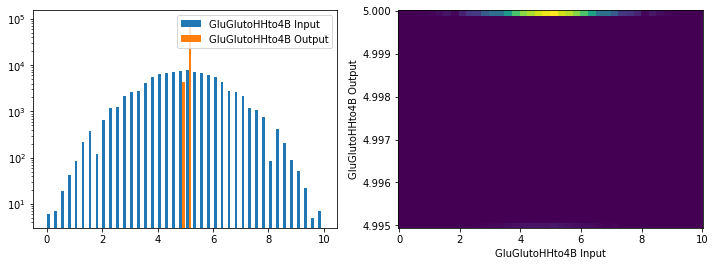

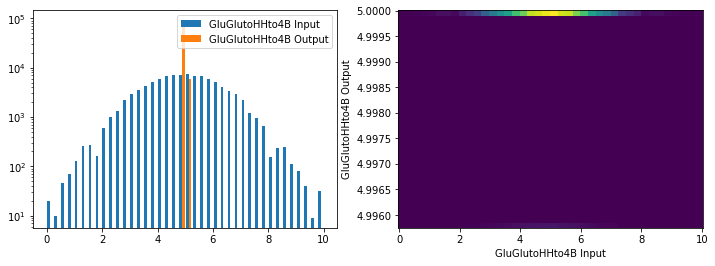

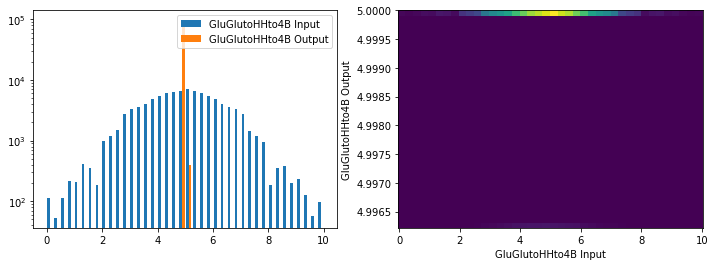

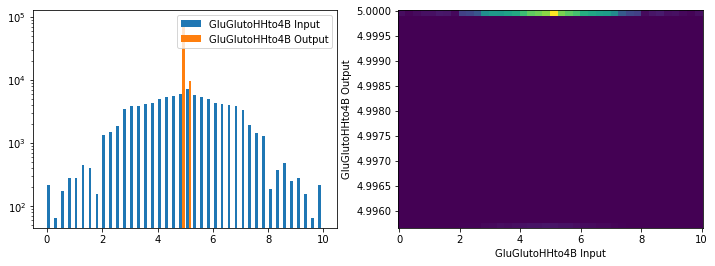

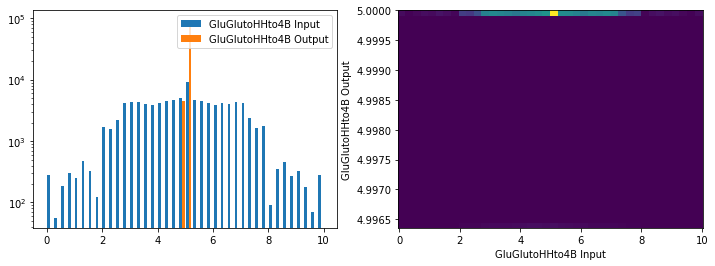

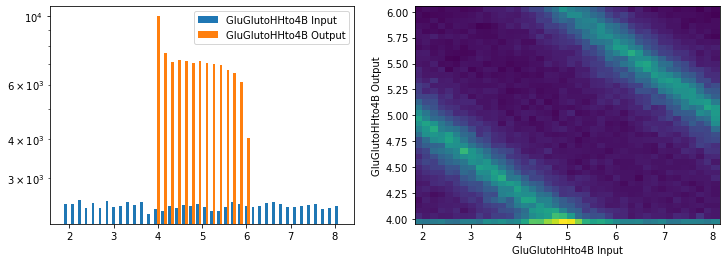

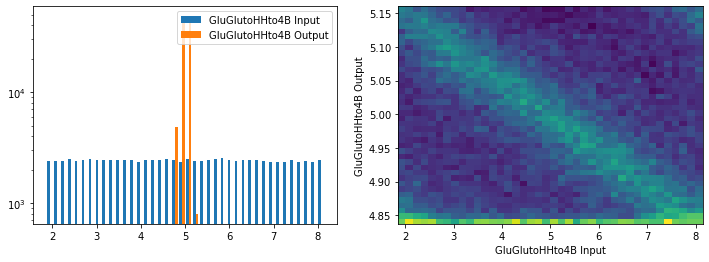

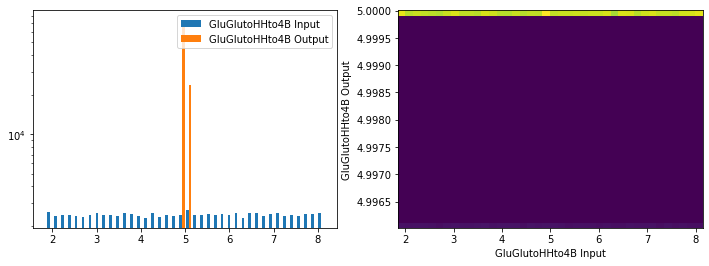

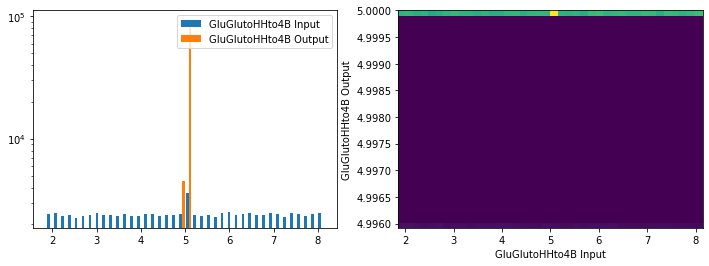

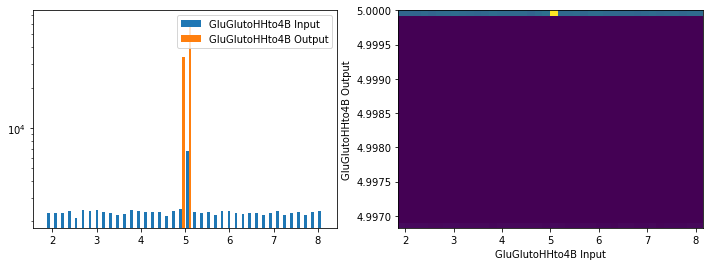

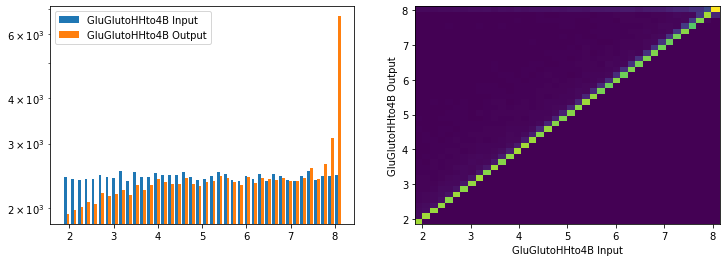

In [17]:
for sample in sampleMap:
    for i in range(sampleMap[sample]['output'].shape[1]):
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.hist([sampleMap[sample]['input'][:,i].flatten(), sampleMap[sample]['output'][:,i].flatten()],bins=40, label=['{} Input'.format(sample), '{} Output'.format(sample)])
        plt.yscale('log')
        plt.legend(loc='best')
        plt.subplot(1,2,2)
        plt.hist2d(sampleMap[sample]['input'][:,i].flatten(),sampleMap[sample]['output'][:,i].flatten(),bins=40)
        plt.xlabel('{} Input'.format(sample))
        plt.ylabel('{} Output'.format(sample))
        plt.show()


### Comparing the latent space

In [18]:
idx_max = 2000
from sklearn.manifold import TSNE

z_dset = np.array([])
for sample in sampleMap:
    z_dset = np.concatenate((z_dset, sampleMap[sample]['latent'][:idx_max])) if z_dset.size else sampleMap[sample]['latent'][:idx_max]
z_embedded = TSNE(n_components=2).fit_transform(z_dset)


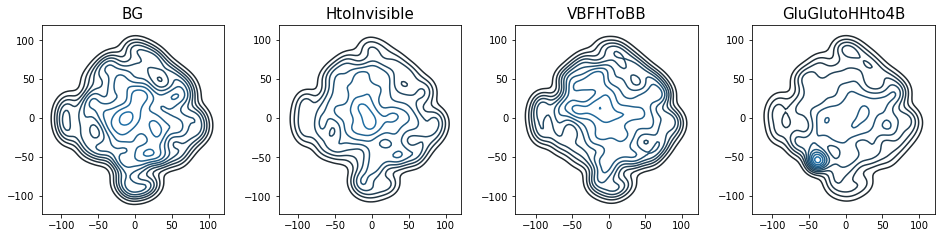

In [19]:
import seaborn as sns
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, sample in enumerate(sampleMap):
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    ax = plt.subplot(2,4,i+1)
    sns.kdeplot(aux_z[:,0], aux_z[:,1], ax=ax)
    ax.set_title(sample, fontsize=15)
plt.show()
        

### Compare the output of different processes (BG and all Signal) to see if they are really the same

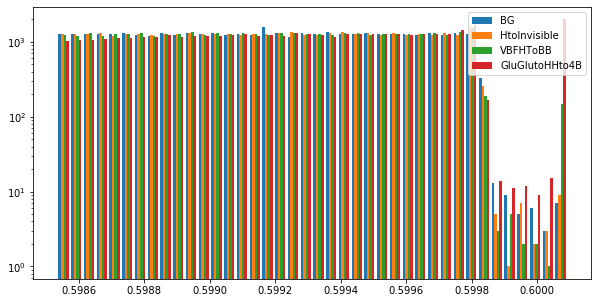

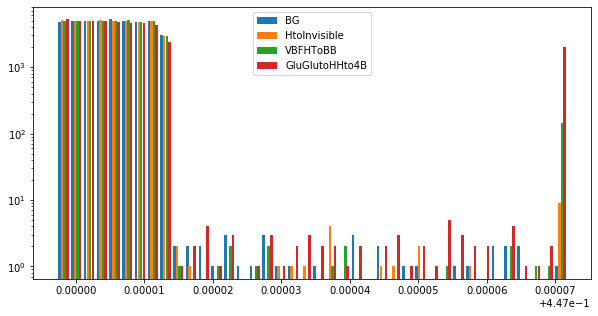

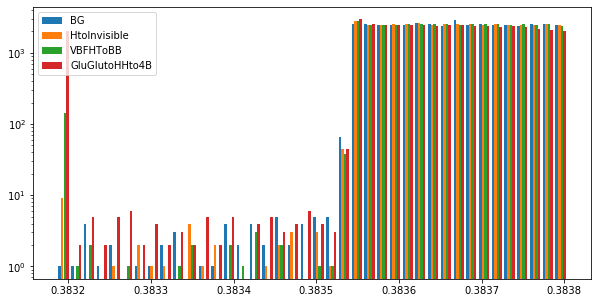

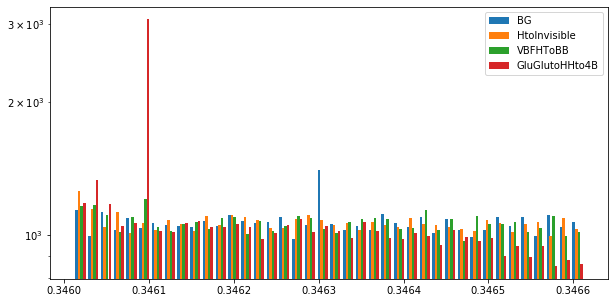

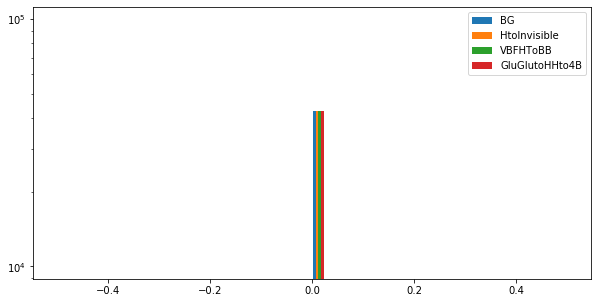

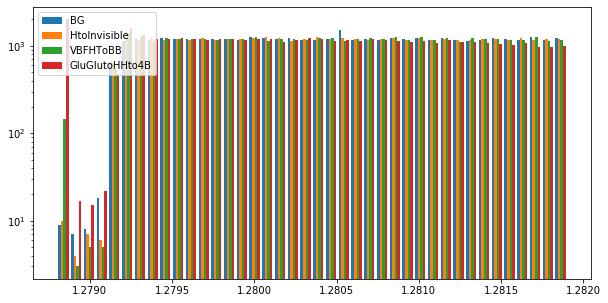

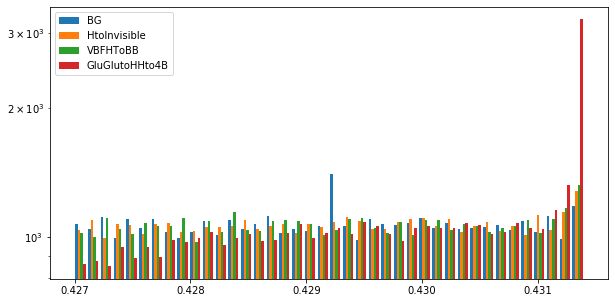

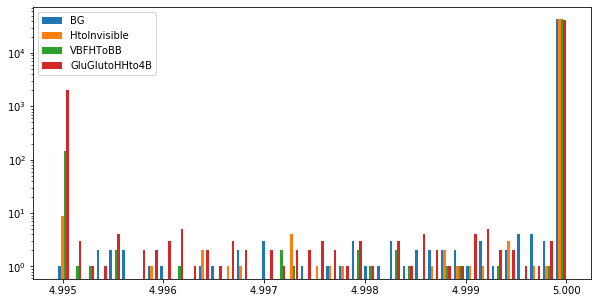

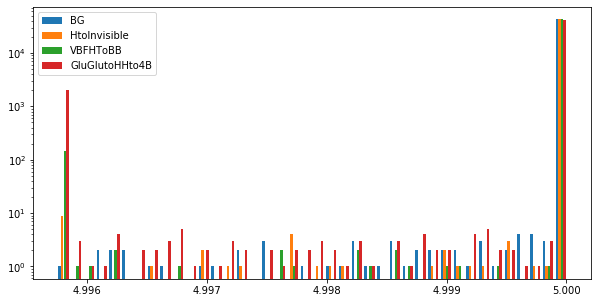

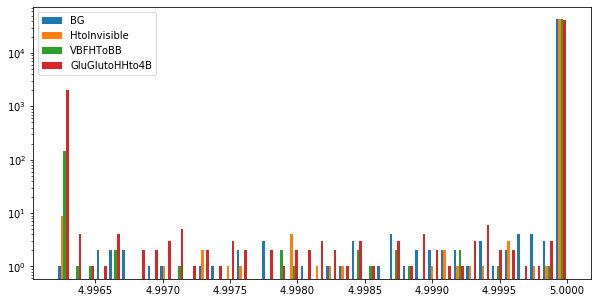

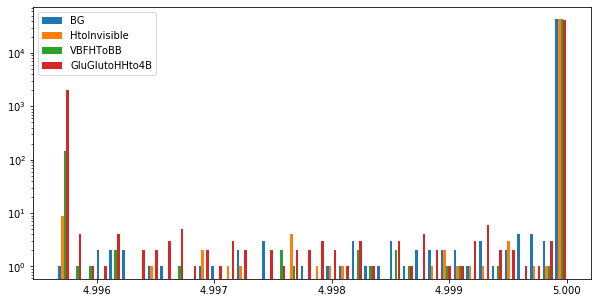

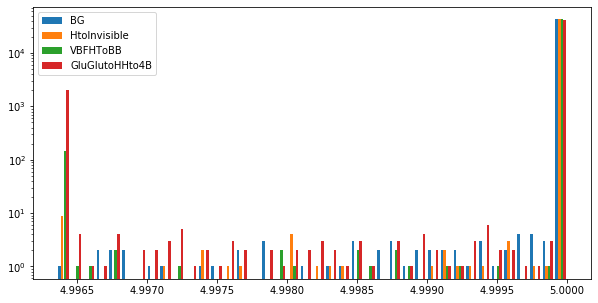

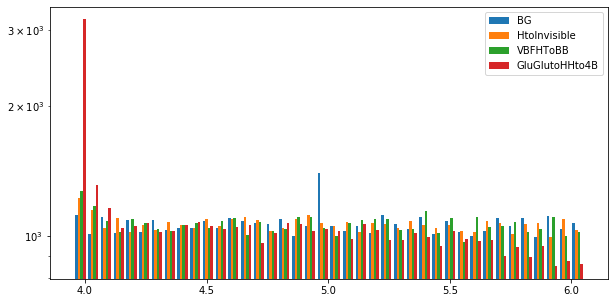

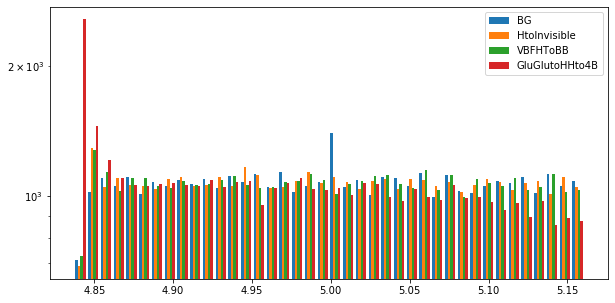

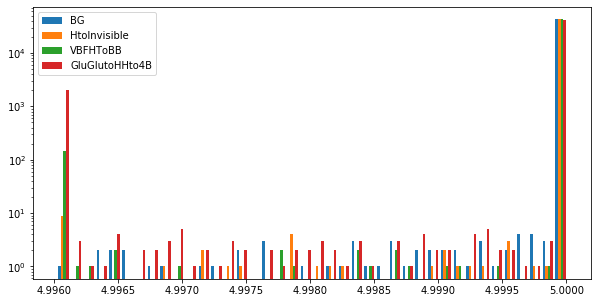

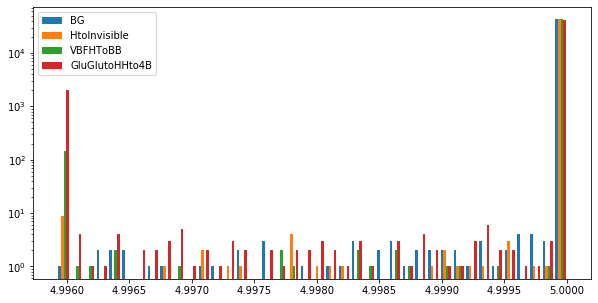

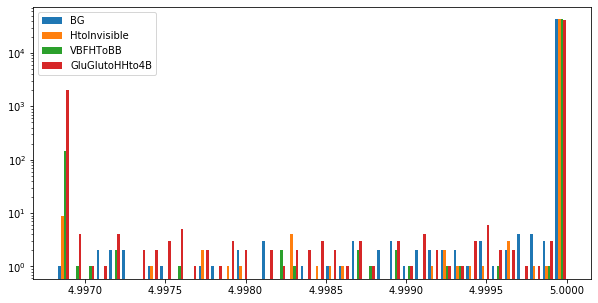

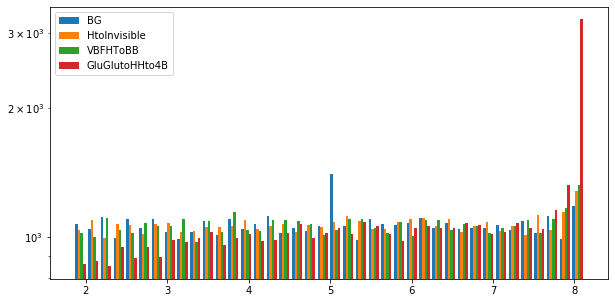

In [23]:
maxEvents = min([len(sampleMap[sample]['output']) for sample in sampleMap])
print("Max events = {}".format(maxEvents))
for i in range(sampleMap[sample]['output'].shape[1]):
    plt.figure(figsize=(10,5))
    plt.hist([sampleMap[sample]['output'][:maxEvents,i].flatten() for sample in sampleMap.keys()],bins=40, label=list(sampleMap.keys()))
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()


## Compare the discriminator performance between using AE loss vs. using sum of features

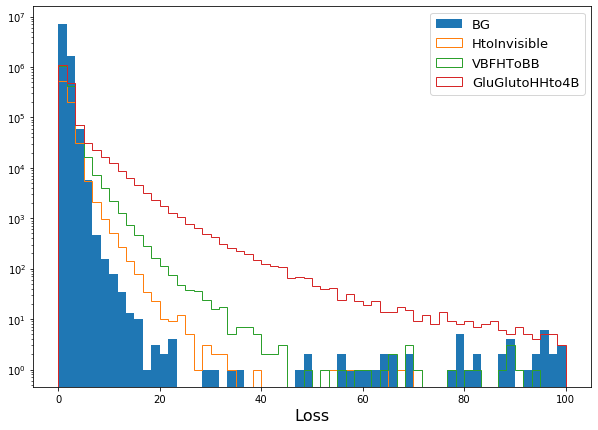

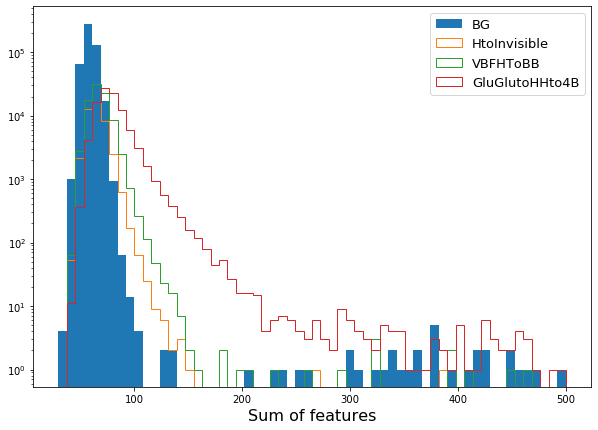

In [34]:
plt.figure(figsize=(10,7))
for sample in sampleMap:
    plt.hist(sampleMap[sample]['loss'].flatten(), label=sample, 
             histtype=sampleMap[sample]['histtype'], 
             bins=60, range=(0,100))
    plt.xlabel('Loss', fontsize=16)
    plt.yscale('log')
plt.legend(loc='best', fontsize=13)
plt.show()

plt.figure(figsize=(10,7))
for sample in sampleMap:
    sampleMap[sample]['featureSum'] = np.sum(sampleMap[sample]['input'], axis=1)
    plt.hist(sampleMap[sample]['featureSum'].flatten(), label=sample, 
             histtype=sampleMap[sample]['histtype'], 
             bins=60, range=(30,500))
    plt.xlabel('Sum of features', fontsize=16)
    plt.yscale('log')
plt.legend(loc='best', fontsize=13)
plt.show()


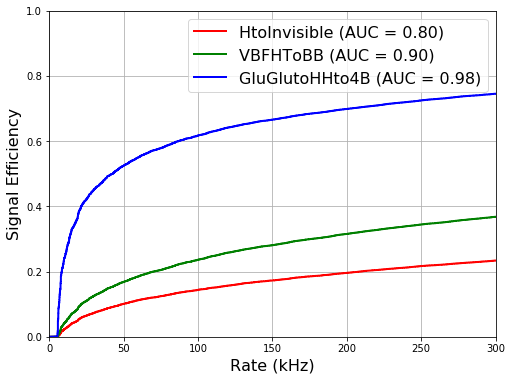

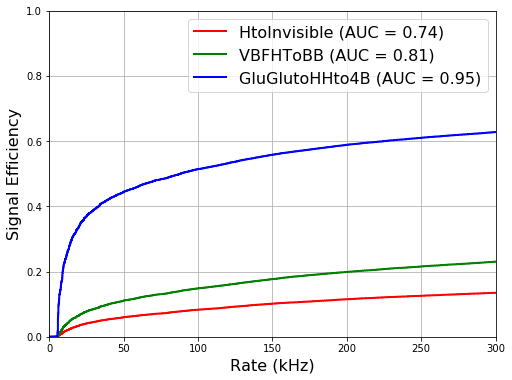

In [50]:
def DrawROC(modelname, lossMap, features):
    plt.figure(figsize=(8,6))
    if len(lossMap['BG'].shape) > 1:
        reshape_bg_loss = np.reshape(lossMap["BG"], (-1,features))
        bloss = np.sum(reshape_bg_loss, axis=1).flatten()
    else:
        reshape_bg_loss = lossMap['BG']
        bloss = reshape_bg_loss.flatten()
    for k, v in lossMap.items():
        if k == "BG":
            continue
        if len(v.shape) > 1:
            reshape_vbg_loss = np.reshape(v, (-1,features))
            vloss = np.sum(reshape_vbg_loss, axis=1).flatten()
        else:
            vloss = v.flatten()
        Tr = np.concatenate(( np.zeros_like(bloss), np.ones_like(vloss)), axis=0)
        Loss = np.concatenate((bloss, vloss), axis=0)
        fpr, tpr, thresholds = roc_curve(Tr, Loss)
        roc_auc = auc(fpr, tpr)
        rate = fpr * 40*1000
        plt.plot(rate, tpr, color=sampleMap[k]['color'],
                 lw=2, label='%s (AUC = %0.2f)' % (sampleMap[k]['label'], roc_auc))
    plt.legend(loc='best',fontsize=16)
    plt.xlabel('Rate (kHz)', fontsize=16)
    plt.ylabel('Signal Efficiency', fontsize=16)
    #plt.savefig("%s_ROC.png" % modelname)
    plt.xlim(0,300)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()

lossMap = {}
sumMap = {}
features = sum([v[0] for b, v in PhysicsObt.items()])

for k, v in sampleMap.items():
    lossMap[k] = sampleMap[k]['loss']
    sumMap[k] = sampleMap[k]['featureSum']

DrawROC(modelname, lossMap, features)
DrawROC(modelname, sumMap, features)
print("Top is using AE loss. Bottom is using sum of all features")

In [49]:
sampleMap[sample]['input'].shape

(97504, 18)